In [8]:
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'false'


In [7]:
# load dataset
import pandas as pd
mts_df = pd.read_csv("./Dataset/our_revised_v2.csv", usecols=["data"])
mts_df.head()

,data
0,This 60-year-old male was hospitalized due to ...
1,A 39-year-old man was hospitalized due to an i...
2,One week after a positive COVID-19 result this...
3,This 69-year-old male was admitted to the ICU ...
4,This 57-year-old male was admitted to the ICU ...


In [9]:
# Create model and prompt template
local_llm = 'llama3'
# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)
prompt = PromptTemplate(
    template="""
        You are a world-class algorithm for extracting information in structured formats. 
        Extract demographic features names without values from the patient description in a JSON format. 
        
        The patient description:
        {description}
        """,
    input_variables=["description"],
)

feature_explorer_model = prompt | llm | JsonOutputParser()




In [63]:
from tqdm.notebook import tqdm
from collections import defaultdict

# Because running the model is time-consuming I am going to run it for 100 data points.

demographic_features = defaultdict(lambda : 0)
for i, row in tqdm(mts_df.iloc[:100].iterrows()):
    output = feature_explorer_model.invoke({"description": row['data']})
    output = list(output.values())[0]
    # try:
    for item in output:
        # print(item)
        if isinstance(item, dict):
            item = list(item.values())
            feature = item[0].lower()
        elif isinstance(item, str):
            # print("str", item)
            feature = item.lower()
        else:
            print(type(item), output)
            raise RuntimeError()
        demographic_features[feature] += 1
    # except:
    #     print(output)

0it [00:00, ?it/s]

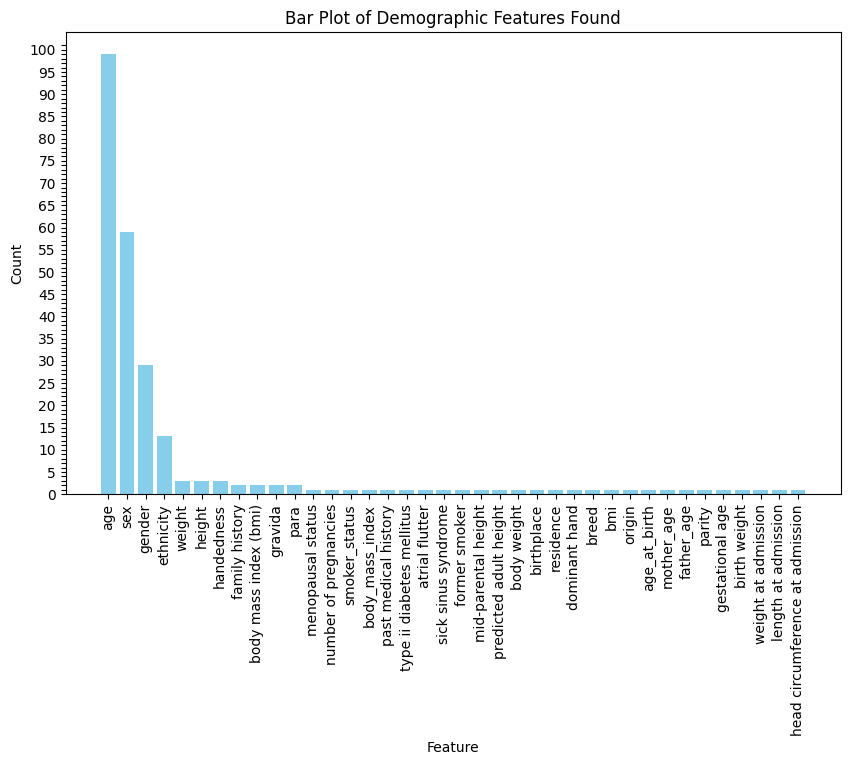

In [83]:
import matplotlib.pyplot as plt

sorted_demographic_features = dict(sorted(demographic_features.items(), key=lambda item: item[1],reverse=True))
sorted_demographic_features
keys = list(sorted_demographic_features.keys())
values = list(sorted_demographic_features.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title('Bar Plot of Demographic Features Found')
plt.xticks(rotation=90)
y_ticks = range(0, max(values) + 3)
y_labels = [str(tick) if tick % 5 == 0 else '' for tick in y_ticks]
plt.yticks(ticks=y_ticks, labels=y_labels)

plt.show()

In [95]:
# Select top k features based on their count
k = 4
final_demographic_features = sorted(demographic_features, key=demographic_features.get, reverse=True)[:k]
final_demographic_features.pop(2)
final_demographic_features

['age', 'sex', 'ethnicity']

In [127]:
# prompt_text = """
# You are a world-class algorithm for extracting information in structured formats. 
# Extract the attribute values from the patient descriptions in a JSON format. 
# Valid attributes are Disease, """ + ", ".join(final_demographic_features[:-1]) + """, Survival Status if died or survived or unknown. 
# If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

# prompt_text = """
# Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are Disease Type, Age, Ethnicity, Sex, Disease Severity, Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

# prompt_text = """
# Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are each patient’s disease status (treated, mild, moderate, severe) and which disease, Age, Ethnicity, Sex, , Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.
# 
# The patient description:
# {description}
# """

prompt_text = """
Extract the attribute values from the patient descriptions in a JSON format. Valid attributes are Disease Type, Age, Ethnicity, Sex, Disease Severity, disease treated or not, Survival Status. If an attribute is not present in the product title, the attribute value is supposed to be 'n/a'.

The patient description:
{description}
"""


prompt = PromptTemplate(
    template=prompt_text,
    input_variables=["description"],
)

feature_extractor_model = prompt | llm | JsonOutputParser()



In [148]:
description =""""A 40-year-old male engineer, former professional rugby player, was referred to our clinic with a left heel inflammatory pain that was worsening during jogging or trailing. The symptoms started seven months before and the patient presented to a regional local hospital for investigations where a plain radiography was performed and a simple bone cyst diagnosis was suspected. Patient was recommended a break from physical activity for six months and non-steroid anti-inflammatories drugs (NSAIDS) to ameliorate pain. The pain increased gradually and he started to complain of swelling. The pain was hardly controlled with NSAIDS and non-morphinic analgesics.
Our clinical examination revealed a mild tenderness in the posterior foot, including the ankle and the heel, without evidence of a palpable mass. Ankle and subtalar joint mobilities were limited. The laboratory blood tests and urine analysis results were normal.
Radiography revealed a benign-appearing bone lesion of 16 Ã— 19 mm within the anteroinferior part of the calcaneum which was well defined, radiolucent, almost entirely homogeneous with a small central sclerotic focus-â€œCockade signâ€ [,], describing the classical appearance of a calcaneal intraosseous lipoma (). We also performed and MRI exam that showed a focal lesion, hyperintense on both T1 and T2 weighted images, and isointense with fatty tissues (a,b). There was a discreet focal attenuation in the center of the lesion, on T2* sequence, suggestive for focal calcification (c). The MRI aspect corresponded to a Milgram type II intraosseous lipoma (predominantly fatty lesions with central necrosis/calcifications/ ossifications) [].
Surgery was performed and a direct lateral approach to the calcaneum was chosen. The saphenous nerve and the long peroneus tendon were reclined superiorly and distally (a). A bone window was performed immediate distally to the lateral tubercle"
"""
print(feature_extractor_model.invoke({"description": description}))


{'Disease Type': 'Intraosseous Lipoma', 'Age': 40, 'Ethnicity': 'n/a', 'Sex': 'Male', 'Disease Severity': 'Mild', 'Disease Treated': True, 'Survival Status': 'Alive'}


In [149]:
outputs = []
for i, row in tqdm(mts_df.iloc[:100].iterrows()):
    output = feature_extractor_model.invoke({"description": row['data']})
    outputs.append(output)

0it [00:00, ?it/s]

In [150]:
outputs[-5:]

[{'Disease Type': 'IPH',
  'Age': 2,
  'Ethnicity': 'n/a',
  'Sex': 'boy',
  'Disease Severity': 'severe anemia',
  'Disease Treated': True,
  'Survival Status': 'alive'},
 {'Disease Type': 'IPH',
  'Age': '1-year-old',
  'Ethnicity': 'n/a',
  'Sex': 'girl',
  'Disease Severity': 'repetitive pulmonary hemorrhage',
  'Disease Treated': 'yes',
  'Survival Status': 'alive'},
 {'Disease Type': 'Pulmonary Hemosiderosis',
  'Age': '2-3 years old',
  'Ethnicity': 'n/a',
  'Sex': 'Male',
  'Disease Severity': 'Moderate to Severe',
  'Disease Treated': 'Yes',
  'Survival Status': 'Unknown'},
 {'Disease Type': 'n/a',
  'Age': '20 days old',
  'Ethnicity': 'Korean',
  'Sex': 'Female',
  'Disease Severity': 'Severe metabolic acidosis',
  'Disease Treated': 'Yes',
  'Survival Status': 'Unknown'},
 {'Disease Type': 'Giant cell arteritis (GCA)',
  'Age': 75,
  'Ethnicity': 'Caucasian',
  'Sex': 'Female',
  'Disease Severity': 'Worsened',
  'Disease Treated': True,
  'Survival Status': 'Alive'}]

In [155]:
import pickle
with open('./outputfiles/feature_extractor_outputs.pickle', 'wb') as f:
    pickle.dump(outputs, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('./outputfiles/feature_extractor_outputs.pickle', 'rb') as f:
    outputs = pickle.load(f)